In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping
import os

# Define fixed parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# Define the NEW paths for the Koleroga dataset
# **Replace 'path/to/your/koleroga_dataset' with your actual path**
KOLEROGA_ROOT = './dataset_nut' 
TRAIN_DIR_KOL = os.path.join(KOLEROGA_ROOT, 'train')
TEST_DIR_KOL = os.path.join(KOLEROGA_ROOT, 'test')

# 1. Load Training Data
train_ds_kol = image_dataset_from_directory(
    TRAIN_DIR_KOL,
    labels='inferred',
    label_mode='binary', # For 2 classes
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True, 
    seed=42 # New seed for new data
)

# 2. Load Testing Data
test_ds_kol = image_dataset_from_directory(
    TEST_DIR_KOL,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False, 
    seed=42
)

CLASS_NAMES_KOL = train_ds_kol.class_names
print(f"\n✅ Found {len(CLASS_NAMES_KOL)} classes for Koleroga: {CLASS_NAMES_KOL}")

Found 4449 files belonging to 2 classes.
Found 1113 files belonging to 2 classes.

✅ Found 2 classes for Koleroga: ['Healthy_Nut', 'Mahali_Koleroga']


In [3]:
# 1. Normalization Layer (Pixel values from [0, 255] to [0, 1])
normalization_layer = Rescaling(1./255) 

normalized_train_ds_kol = train_ds_kol.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds_kol = test_ds_kol.map(lambda x, y: (normalization_layer(x), y))

# 2. Dataset Optimization (Caching, Shuffling, Prefetching)
AUTOTUNE = tf.data.AUTOTUNE

# Use .unbatch() and then .batch() to ensure correct shape integrity
train_ds_kol_optimized = normalized_train_ds_kol.unbatch().cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds_kol_optimized = normalized_test_ds_kol.unbatch().cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

print("\n✅ Koleroga Datasets are normalized and optimized.")


✅ Koleroga Datasets are normalized and optimized.


In [4]:
# --- 1. Define Data Augmentation Layers ---
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2), 
  RandomZoom(0.2)      
], name="koleroga_augmentation_layer")

# --- 2. Build Model V3 with Augmentation ---
model_v3 = Sequential([
    data_augmentation, 
    
    # Convolutional Blocks
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.3), 
    
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    # Classification Head
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid') # Binary Classification Output
], name="Koleroga_Predictor_V3")

# --- 3. Compile the Model ---
model_v3.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model_v3.summary()
print("\n✅ Model V3 for Koleroga is built and compiled.")

C:\Users\maham\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Koleroga_Predictor_V3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ koleroga_augmentation_layer          │ ?                           │     0 (unbuilt) │
│ (Sequential)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


✅ Model V3 for Koleroga is built and compiled.


In [5]:
# --- Define Early Stopping Callback ---
# Monitor validation loss and stop if it doesn't improve for 5 epochs, restore the best weights.
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5, 
                           restore_best_weights=True,
                           verbose=1)

# Set epochs high and let EarlyStopping handle when to stop.
EPOCHS_V3 = 50 

print(f"\n--- Starting Model V3 Training for Koleroga for up to {EPOCHS_V3} epochs ---")

history_v3 = model_v3.fit(
    train_ds_kol_optimized,
    validation_data=test_ds_kol_optimized, 
    epochs=EPOCHS_V3,
    callbacks=[early_stop] # Add the EarlyStopping callback
)


--- Starting Model V3 Training for Koleroga for up to 50 epochs ---
Epoch 1/50
    140/Unknown 149s 982ms/step - accuracy: 0.6876 - loss: 1.0007

C:\Users\maham\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


140/140 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.6883 - loss: 0.9974 - val_accuracy: 0.9057 - val_loss: 0.2633
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 132s 946ms/step - accuracy: 0.8838 - loss: 0.2821 - val_accuracy: 0.9066 - val_loss: 0.2044
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 118s 842ms/step - accuracy: 0.9200 - loss: 0.1799 - val_accuracy: 0.9263 - val_loss: 0.2024
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 112s 797ms/step - accuracy: 0.9515 - loss: 0.1408 - val_accuracy: 0.9371 - val_loss: 0.1824
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 111s 789ms/step - accuracy: 0.9581 - loss: 0.1289 - val_accuracy: 0.9641 - val_loss: 0.1037
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 120s 857ms/step - accuracy: 0.9546 - loss: 0.1438 - val_accuracy: 0.9766 - val_loss: 0.0829
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 108s 772ms/step - accuracy: 0.9708 - loss: 0.0834 - val_accuracy: 0.9829 - val_loss: 0.0529
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 106s 758ms/step - accuracy: 0.9788 - loss: 0.0616 

In [7]:
print("y")

y


In [8]:
import os

# Define the file path for the saved model
MODEL_SAVE_PATH_KOL = 'arecanut_koleroga_predictor_v3.keras'

# Save the model
model_v3.save(MODEL_SAVE_PATH_KOL)

print(f"\n✅ Koleroga Model V3 (Best Weights from Epoch 7) successfully saved to: {MODEL_SAVE_PATH_KOL}")
print("This model is now ready for deployment!")


✅ Koleroga Model V3 (Best Weights from Epoch 7) successfully saved to: arecanut_koleroga_predictor_v3.keras
This model is now ready for deployment!


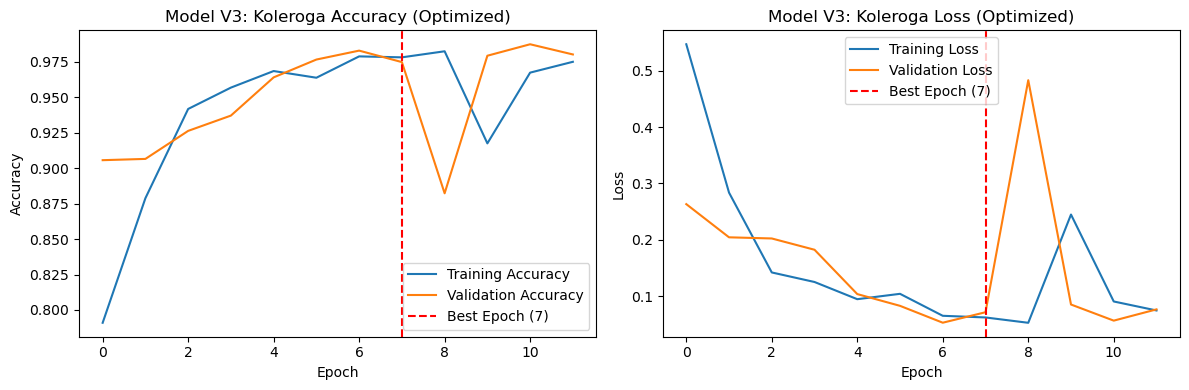

In [9]:
import matplotlib.pyplot as plt

# Assuming 'history_v3' is the variable returned by the model_v3.fit()

# 1. Plot Training and Validation Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_v3.history['accuracy'], label='Training Accuracy')
plt.plot(history_v3.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=7, color='r', linestyle='--', label='Best Epoch (7)') # Mark the best epoch
plt.title('Model V3: Koleroga Accuracy (Optimized)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2. Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_v3.history['loss'], label='Training Loss')
plt.plot(history_v3.history['val_loss'], label='Validation Loss')
plt.axvline(x=7, color='r', linestyle='--', label='Best Epoch (7)') # Mark the best epoch
plt.title('Model V3: Koleroga Loss (Optimized)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


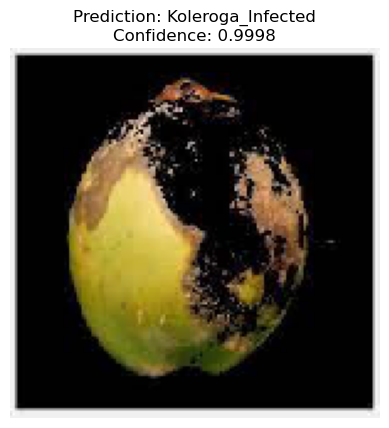


-------------------------------------------------
Prediction Result: **Koleroga_Infected**
Confidence Level: **0.9998**
-------------------------------------------------


In [11]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# --- 1. Define Fixed Parameters ---
IMG_HEIGHT = 150
IMG_WIDTH = 150
# NOTE: Set this to the model you want to test (YLD or Koleroga)
MODEL_SAVE_PATH = 'arecanut_koleroga_predictor_v3.keras' # Assuming you want to test Koleroga
CLASS_NAMES = ['Healthy_Fruit', 'Koleroga_Infected'] 

# =========================================================================
# 🛑 ACTION REQUIRED: REPLACE THIS PATH WITH YOUR ACTUAL IMAGE FILE PATH
# =========================================================================
IMAGE_TO_TEST_PATH = './Mahali_Koleroga_original_71.jpg_af8c9c79-30c3-47b1-95a2-c597097ccb57.jpg' 
# =========================================================================


# --- 2. Define Prediction Function ---
def predict_real_image(img_path, model, class_names):
    
    # Load the image and resize it
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    # Convert image to a numpy array
    img_array = image.img_to_array(img)
    # Expand dimensions to create a batch (1, 150, 150, 3)
    img_batch = np.expand_dims(img_array, axis=0) 
    
    # Apply normalization (model V3 expects [0, 1] input)
    normalized_img_batch = img_batch / 255.0

    # --- 3. Predict ---
    prediction = model.predict(normalized_img_batch)
    
    # Binary Classification (sigmoid output: 0 to 1)
    prob = prediction[0][0]
    
    if prob > 0.5:
        result = class_names[1]
        confidence = prob
    else:
        result = class_names[0]
        confidence = 1 - prob # Confidence for the '0' class
        
    return result, confidence, img

# --- 4. Load Model and Execute Test ---
try:
    loaded_model = load_model(MODEL_SAVE_PATH)
    
    # Run the prediction
    disease, prob, img_loaded = predict_real_image(IMAGE_TO_TEST_PATH, loaded_model, CLASS_NAMES)

    # --- 5. Display Result ---
    plt.imshow(img_loaded)
    plt.title(f"Prediction: {disease}\nConfidence: {prob:.4f}")
    plt.axis('off')
    plt.show()

    print("\n-------------------------------------------------")
    print(f"Prediction Result: **{disease}**")
    print(f"Confidence Level: **{prob:.4f}**")
    print("-------------------------------------------------")

except FileNotFoundError:
    print(f"\n❌ ERROR: Image file not found at the specified path: {IMAGE_TO_TEST_PATH}")
    print("Please ensure the path to your image file is 100% correct.")
except Exception as e:
    print(f"\n❌ An error occurred during prediction: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


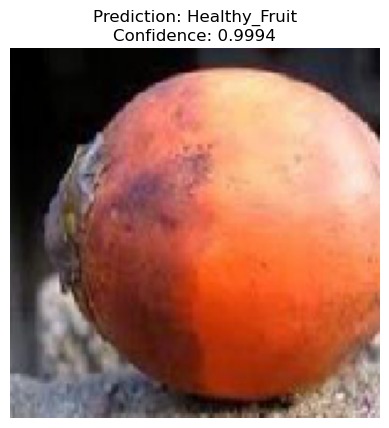


-------------------------------------------------
Prediction Result: **Healthy_Fruit**
Confidence Level: **0.9994**
-------------------------------------------------


In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# --- 1. Define Fixed Parameters ---
IMG_HEIGHT = 150
IMG_WIDTH = 150
# NOTE: Set this to the model you want to test (YLD or Koleroga)
MODEL_SAVE_PATH = 'arecanut_koleroga_predictor_v3.keras' # Assuming you want to test Koleroga
CLASS_NAMES = ['Healthy_Fruit', 'Koleroga_Infected'] 

# =========================================================================
# 🛑 ACTION REQUIRED: REPLACE THIS PATH WITH YOUR ACTUAL IMAGE FILE PATH
# =========================================================================
IMAGE_TO_TEST_PATH = './Healthy_Nut_original_40.jpg_d8d149ff-9902-4889-9a6a-c6a34429d2e4.jpg' 
# =========================================================================


# --- 2. Define Prediction Function ---
def predict_real_image(img_path, model, class_names):
    
    # Load the image and resize it
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    # Convert image to a numpy array
    img_array = image.img_to_array(img)
    # Expand dimensions to create a batch (1, 150, 150, 3)
    img_batch = np.expand_dims(img_array, axis=0) 
    
    # Apply normalization (model V3 expects [0, 1] input)
    normalized_img_batch = img_batch / 255.0

    # --- 3. Predict ---
    prediction = model.predict(normalized_img_batch)
    
    # Binary Classification (sigmoid output: 0 to 1)
    prob = prediction[0][0]
    
    if prob > 0.5:
        result = class_names[1]
        confidence = prob
    else:
        result = class_names[0]
        confidence = 1 - prob # Confidence for the '0' class
        
    return result, confidence, img

# --- 4. Load Model and Execute Test ---
try:
    loaded_model = load_model(MODEL_SAVE_PATH)
    
    # Run the prediction
    disease, prob, img_loaded = predict_real_image(IMAGE_TO_TEST_PATH, loaded_model, CLASS_NAMES)

    # --- 5. Display Result ---
    plt.imshow(img_loaded)
    plt.title(f"Prediction: {disease}\nConfidence: {prob:.4f}")
    plt.axis('off')
    plt.show()

    print("\n-------------------------------------------------")
    print(f"Prediction Result: **{disease}**")
    print(f"Confidence Level: **{prob:.4f}**")
    print("-------------------------------------------------")

except FileNotFoundError:
    print(f"\n❌ ERROR: Image file not found at the specified path: {IMAGE_TO_TEST_PATH}")
    print("Please ensure the path to your image file is 100% correct.")
except Exception as e:
    print(f"\n❌ An error occurred during prediction: {e}")